# Outlier Detection Using iForest for Credit Card Data


* Motivation:

Following up on our last assigment using autoencoders to detect outliers, now I'll delve into another simpler but very efficient method for outlier detection: Isolation Forests. The PyOD library has special implemantion of the isolation forest algorithm that uses 


* Resources:
        
        *Modified Dataset on Credit Card Transactions.
        *Outlier Detection Models.
        *Visualization tools to determine thresholds.
        
* Methods:
        
        *PyOD Library to run an isolation forest algorithm.
        *CrossValidate Results using Average and Maximization.
        
        
* Objective:

By using the already modified dataset on Credit Card Transaction Data identify which observations can be described as outliers and provide a brief description as to why the algorithm picked those.

In [12]:
#Loading the Libraries
import pandas as pd
import os
import numpy as np
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pyod.models.combination import average, maximization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
#Setting up the Data
os.chdir("/Users/luislosada/Columbia Drive/Anomaly Detection/Module 7")
flag_data = pd.read_csv("flag_aggregated_dataset.csv",index_col=0).reset_index(drop=True)


In [14]:
flag_data.iloc[:,3:].describe()

,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount
count,39886.000000,39886.000000,39886.000000,39886.000000,39886.000000
mean,0.001174,0.111329,0.000994,0.151595,0.067518
std,0.029430,0.299258,0.021926,0.293093,0.212029
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.160000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [87]:
#Splitting the Data to test the results of the iForest
X_train, X_test = train_test_split(flag_data.iloc[:,3:], test_size=0.2)


### Isolation Forest

Isolation forest is based on the basis of a random forest algorithm and its objective is to determine scores for each observation based on how far or how close from the root node in a tree the observation is isolated. Because of its simplicity and the fact that it does not rely on density or distance measures to detect outliers then this method is usually very fast and requires less computational power than other methods all while still being very accurate at detecting outliers. For this assignment I will use three iForest combination of parameters to determine outliers and then compare the results to select my suspects.

More on iForest [here]('https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf').

In [16]:
clf1 = IForest(behaviour="new", max_samples=100) 
clf1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [33]:
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

#y_test_pred.value_counts()


0   -0.151996
1   -0.234858
2   -0.234858
3    0.033127
4   -0.234858
dtype: float64

In [18]:
y_test_scores.describe()

count    7978.000000
mean       -0.144248
std         0.111988
min        -0.234858
25%        -0.234858
50%        -0.234858
75%        -0.028089
max         0.197577
dtype: float64

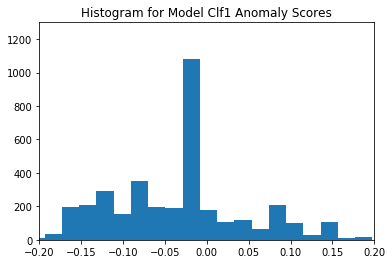

In [19]:
plt.hist(y_test_scores,bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.xlim(-0.2, 0.2)
plt.ylim(0,1300)
plt.show()


We can see that most values fall between -0.20 and 0.20 and the rest of the values seem to be farther off. Lets create a threshold so that anything above 0.20 ore below -0.20 is flagged as an outlier.

In [57]:
df_test = X_test.copy().reset_index(drop=True)
df_test['distance'] = y_test_scores
df_test['cluster'] = np.where((df_test['distance']<0.0) , 0, 1)
df_test['cluster'].value_counts()


0    7172
1     806
Name: cluster, dtype: int64

In [58]:
df_test.head()

,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,distance,cluster
0,0.0,0.0,0.0,0.166667,0.0,-0.151996,0
1,0.0,0.0,0.0,0.000000,0.0,-0.234858,0
2,0.0,0.0,0.0,0.000000,0.0,-0.234858,0
3,0.0,0.0,0.0,0.500000,0.5,0.033127,1
4,0.0,0.0,0.0,0.000000,0.0,-0.234858,0


In [59]:
df_test.groupby('cluster').mean()


,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,distance
cluster,,,,,,
0,0.000717,0.087252,0.000424,0.107913,0.016072,-0.169242
1,0.012609,0.330857,0.001838,0.479520,0.522536,0.078151


We can see the huge spread between the cluster classified as normal and the cluster classified as outlier. The average distance is more than 0.25 points off. It seems then that the cutoff point at 0.20 was the right choice.

Lets now test this theory by using different parameters for the algorithm.

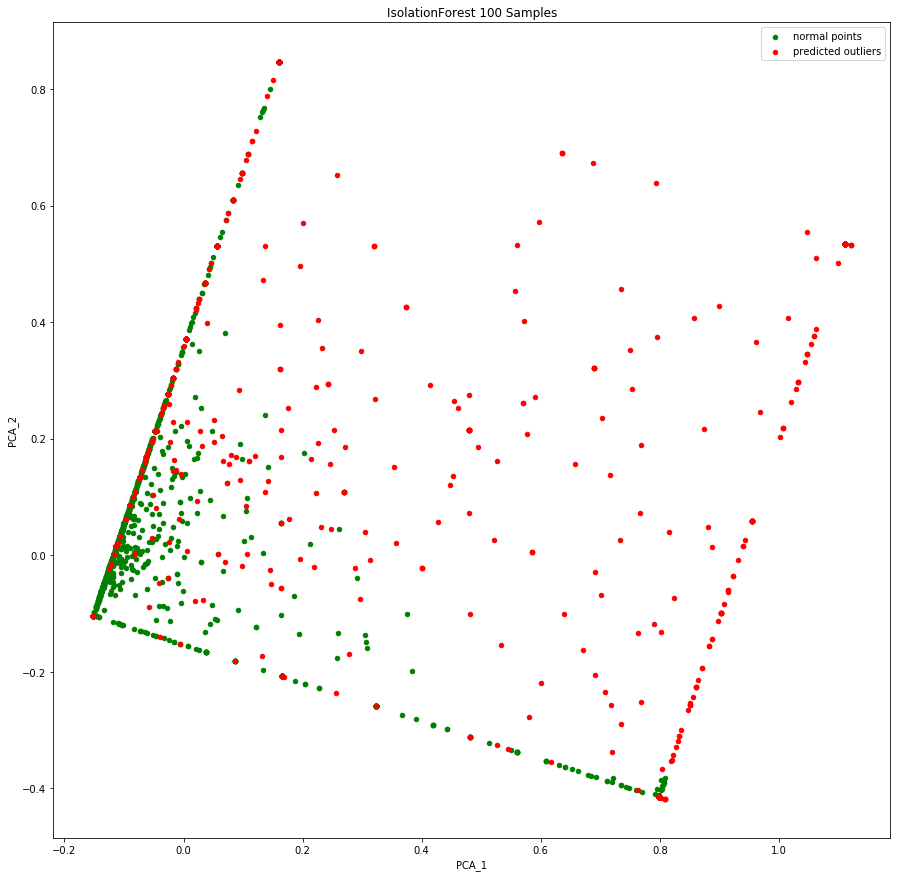

In [61]:
pca = PCA(2)
pca.fit(df_test.iloc[:,0:4])

res = pd.DataFrame({'pca_1':pca.transform(df_test.iloc[:,0:4])[:,0],
 'pca_2':pca.transform(df_test.iloc[:,0:4])[:,1],
 'cluster':df_test.loc[:,'cluster']}).reset_index(drop=True)

#Plotting
plt.figure(figsize=(15,15))

plt.title("IsolationForest 100 Samples")
plt.scatter(res[res.cluster==0].iloc[:,0], res[res.cluster==0].iloc[:,1], c='green',
                 s=20,label="normal points")
plt.scatter(res[res.cluster==1].iloc[:,0], res[res.cluster==1].iloc[:,1], c='red',
                 s=20,label="predicted outliers")
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')


plt.legend(loc="upper right")
plt.show()


In [62]:
clf2 = IForest(behaviour="new", max_samples=80) 
clf2.fit(X_train)
y_test_scores_2 = clf2.decision_function(X_test)  # outlier scores
y_test_scores_2 = pd.Series(y_test_scores_2)


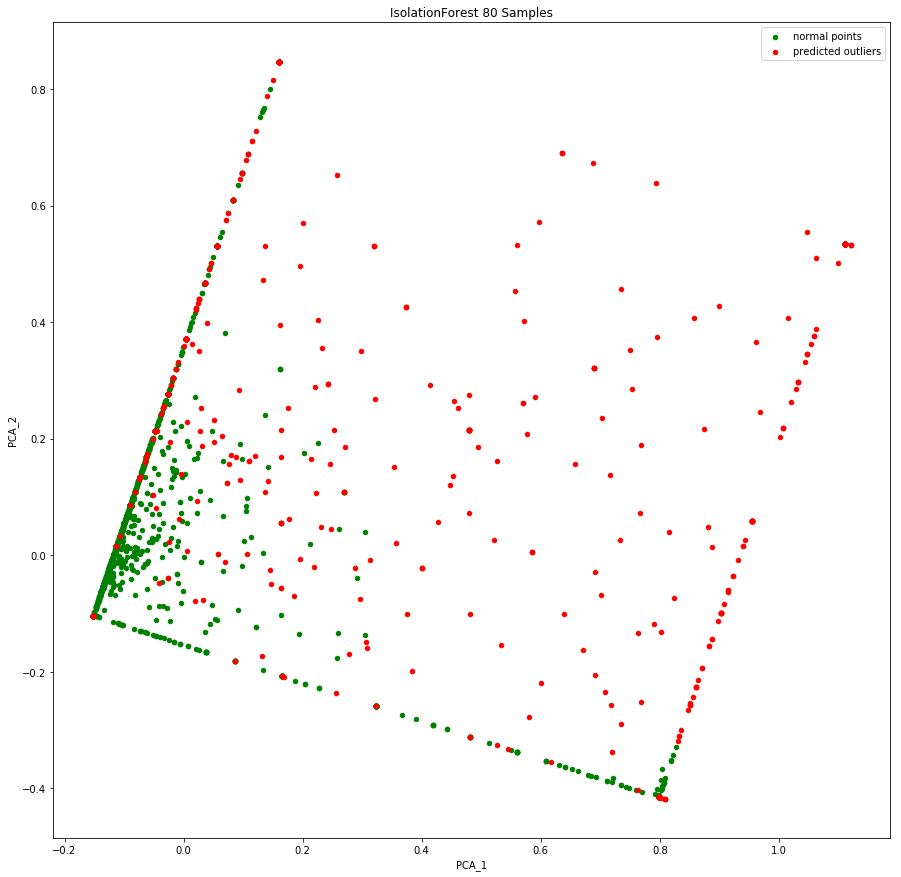

In [64]:
df_test_2 = X_test.copy().reset_index(drop=True)
df_test_2['distance'] = y_test_scores_2
df_test_2['cluster'] = np.where(df_test_2['distance']<0.0, 0, 1)

res = pd.DataFrame({'pca_1':pca.transform(df_test_2.iloc[:,0:4])[:,0],
 'pca_2':pca.transform(df_test_2.iloc[:,0:4])[:,1],
 'cluster':df_test_2.loc[:,'cluster']}).reset_index(drop=True)

#Plotting
plt.figure(figsize=(15,15))

plt.title("IsolationForest 80 Samples")
plt.scatter(res[res.cluster==0].iloc[:,0], res[res.cluster==0].iloc[:,1], c='green',
                 s=20,label="normal points")
plt.scatter(res[res.cluster==1].iloc[:,0], res[res.cluster==1].iloc[:,1], c='red',
                 s=20,label="predicted outliers")
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')


plt.legend(loc="upper right")
plt.show()

In [54]:
clf3 = IForest(behaviour="new", max_samples=60) 
clf3.fit(X_train)
y_test_scores_3 = clf3.decision_function(X_test)  # outlier scores
y_test_scores_3 = pd.Series(y_test_scores_3)


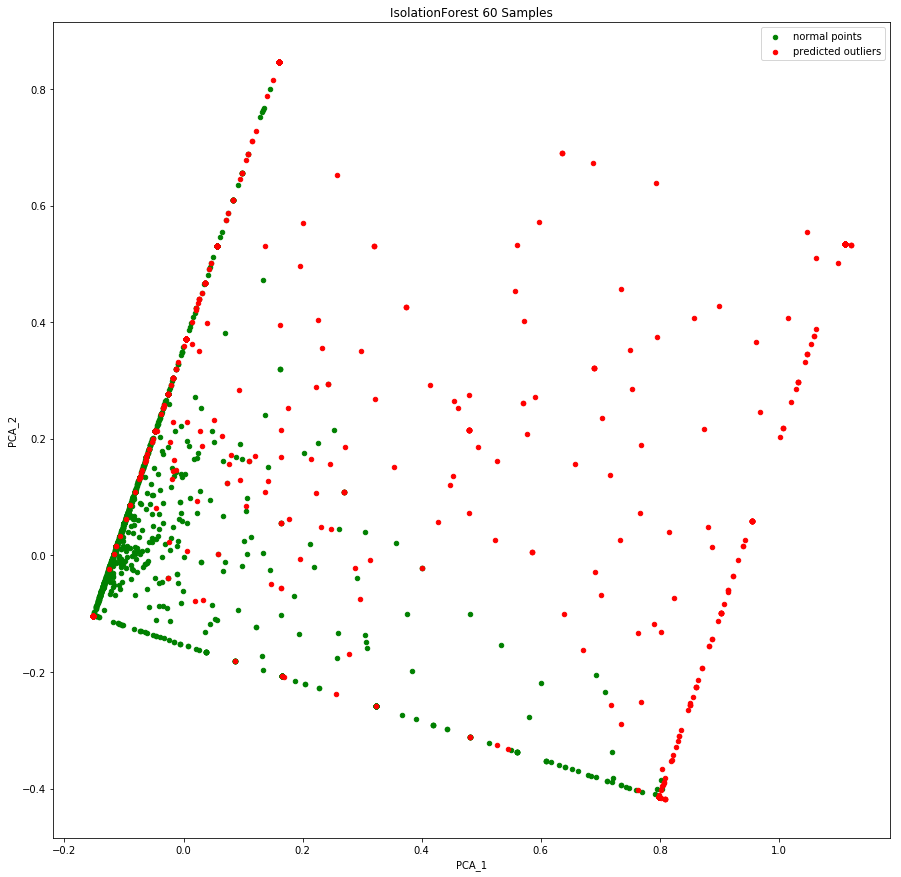

In [65]:
df_test_3 = X_test.copy().reset_index(drop=True)
df_test_3['distance'] = y_test_scores_3
df_test_3['cluster'] = np.where(df_test_3['distance']<0.0, 0, 1)

res = pd.DataFrame({'pca_1':pca.transform(df_test_3.iloc[:,0:4])[:,0],
 'pca_2':pca.transform(df_test_3.iloc[:,0:4])[:,1],
 'cluster':df_test_3.loc[:,'cluster']}).reset_index(drop=True)

#Plotting
plt.figure(figsize=(15,15))

plt.title("IsolationForest 60 Samples")
plt.scatter(res[res.cluster==0].iloc[:,0], res[res.cluster==0].iloc[:,1], c='green',
                 s=20,label="normal points")
plt.scatter(res[res.cluster==1].iloc[:,0], res[res.cluster==1].iloc[:,1], c='red',
                 s=20,label="predicted outliers")
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')


plt.legend(loc="upper right")
plt.show()

#### Highlights
A couple of things to observe:

- Because this measures the distance from the root to the terminal node of each observation then observations that share the same charactericts also share the same scores.
- The value -0.23... seems to repeat itself quite a lot. The reason for this is that observations with no flags will then be identical obsrvations for the purpose of this algorithm and thus produce the same results.
- Most values fall into the negative side of the score which means that outliers are most likely to appear when values go above 0.

#### Validating Results

Now lets see if the split between train and trest and the scores of all three algorithm make sense before continuing forward.

In [70]:
#Creating a dataset to compare results.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })
train_scores.describe()

,clf1,clf2,clf3
count,31908.000000,31908.000000,31908.000000
mean,-0.142807,-0.155469,-0.146316
std,0.112228,0.120015,0.115685
min,-0.234858,-0.255492,-0.241778
25%,-0.234858,-0.255492,-0.241778
50%,-0.234858,-0.255492,-0.241778
75%,-0.028089,-0.027304,-0.029194
max,0.197577,0.177699,0.171577


In [71]:
test_scores.describe()

,clf1,clf2,clf3
count,7978.000000,7978.000000,7978.000000
mean,-0.144248,-0.157232,-0.148037
std,0.111988,0.119531,0.115274
min,-0.234858,-0.255492,-0.241778
25%,-0.234858,-0.255492,-0.241778
50%,-0.234858,-0.255492,-0.241778
75%,-0.028089,-0.036443,-0.036718
max,0.197577,0.177699,0.171577


#### Model Combination

A great to validate the scores obtained is to combine the scores of the three models built. There are several techniques for this but in this case, I will use two methods:

- Average: Which takes the average score of all three algorithms produced above and creates an aggregated score.
- Max Score: Takes the max score of all three methods and outputs that score as the score for that observation.



In [73]:
#Average using PyOD
y_by_average = average(test_scores)
pd.Series(y_by_average).describe()


count    7978.000000
mean       -0.149839
std         0.115386
min        -0.244043
25%        -0.244043
50%        -0.244043
75%        -0.035238
max         0.182284
dtype: float64

With this average score, we take into account the results of all models built and create an aggregated score, therefore reducing the chance of overfitting and underfitting the data.

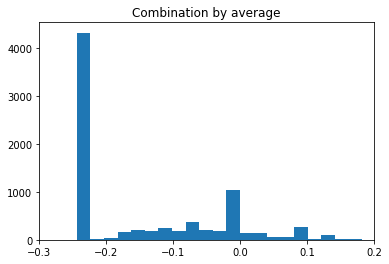

In [75]:
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.xlim(-.3, 0.2)
plt.show()



Just as expected, the results look pretty similar to the original set and there is big concentration of values at the -0.23 mark. It does seem that the outliers detected by the average method are trustworthy then.

In [76]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()


0    7157
1     821
Name: y_by_average_cluster, dtype: int64

In [77]:
df_test.groupby('y_by_average_cluster').mean()


,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,y_by_average_score
y_by_average_cluster,,,,,,
0,0.000720,0.087941,0.000527,0.108765,0.014005,-0.174907
1,0.012364,0.320399,0.000914,0.465304,0.531307,0.068690


The mean values of the outliers and non-outliers produces, again, a very big spread while also reducing the outliers to about 11% of the data. Lets try now with maximization and compare results.

In [78]:
y_by_maximization = maximization(test_scores)
pd.Series(y_by_maximization).describe()


count    7978.000000
mean       -0.139994
std         0.116335
min        -0.234858
25%        -0.234858
50%        -0.234858
75%        -0.020989
max         0.197577
dtype: float64

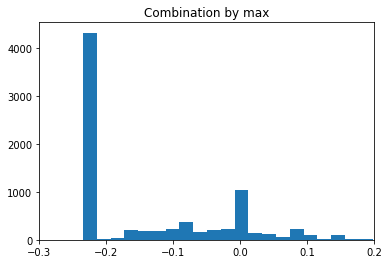

In [81]:
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.xlim(-0.3, 0.2)
plt.show()


In [82]:
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()


0    6587
1    1391
Name: y_by_maximization_cluster, dtype: int64

In [83]:
df_test.groupby('y_by_maximization_cluster').mean()

,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,
0,0.000781,0.013263,0.000462,0.116888,0.014484,-0.188651,0.000000,-0.179362
1,0.007306,0.578776,0.001065,0.280739,0.317058,0.033957,0.590223,0.046428


More outliers are identified by this method than the average score method. The reason being that for each observation the max score was picked which means that the values were skewed a little bit more towards the positive side allowing for more values to pass the threshold. 

### Capturing our Suspects

Even thou the results of the average and max methods are not the same they do share most of the outliers of the set. I'll subset then for observations classified as outliers in both methods and picks those observations as my suspects.

In [84]:
suspicious = df_test[(df_test['y_by_average_cluster'] == 1) & (df_test['y_by_maximization_cluster'] == 1 )]
suspicious.head(20)

,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,y_by_average_score,y_by_average_cluster,y_by_maximization_score,y_by_maximization_cluster
34069,0.0,0.000000,0.0,0.500000,0.500000,0.035467,1,0.039247,1
8066,0.0,0.333333,0.0,0.000000,0.666667,0.090236,1,0.103594,1
33158,0.0,0.000000,0.0,1.000000,0.333333,0.050320,1,0.052677,1
22305,0.0,1.000000,0.0,1.000000,0.000000,0.097206,1,0.109477,1
30388,0.0,0.000000,0.0,0.000000,0.500000,0.003501,1,0.013345,1
31040,0.0,0.000000,0.0,1.000000,1.000000,0.125788,1,0.142961,1
9022,0.0,0.000000,0.0,0.291667,0.500000,0.022377,1,0.028619,1
39651,0.0,0.000000,0.0,1.000000,1.000000,0.125788,1,0.142961,1
32420,0.0,0.000000,0.0,0.500000,1.000000,0.085863,1,0.092642,1
5115,0.0,0.000000,0.0,0.142857,0.714286,0.042453,1,0.048253,1


Now lets compare outliers to non outliers to see if our results make sense.

In [85]:
non_out = df_test[(df_test['y_by_average_cluster'] == 0) & (df_test['y_by_maximization_cluster'] == 0)]
inspect_df = pd.DataFrame({'mean_outliers':suspicious.describe().loc['mean',:],
              'mean_non_outliers':non_out.describe().loc['mean',:]})
inspect_df.drop(['y_by_average_cluster', 'y_by_maximization_cluster'],inplace=True)
inspect_df

,mean_outliers,mean_non_outliers
Flag_Pos_Neg_Mean,0.012364,0.000781
Flag_Ratio_of_Unique_Transactions_Mean,0.320399,0.013263
flag_amount_bin,0.000914,0.000462
flag_week_amount,0.465304,0.116888
flag_month_amount,0.531307,0.014484
y_by_average_score,0.068690,-0.188651
y_by_maximization_score,0.078447,-0.179362


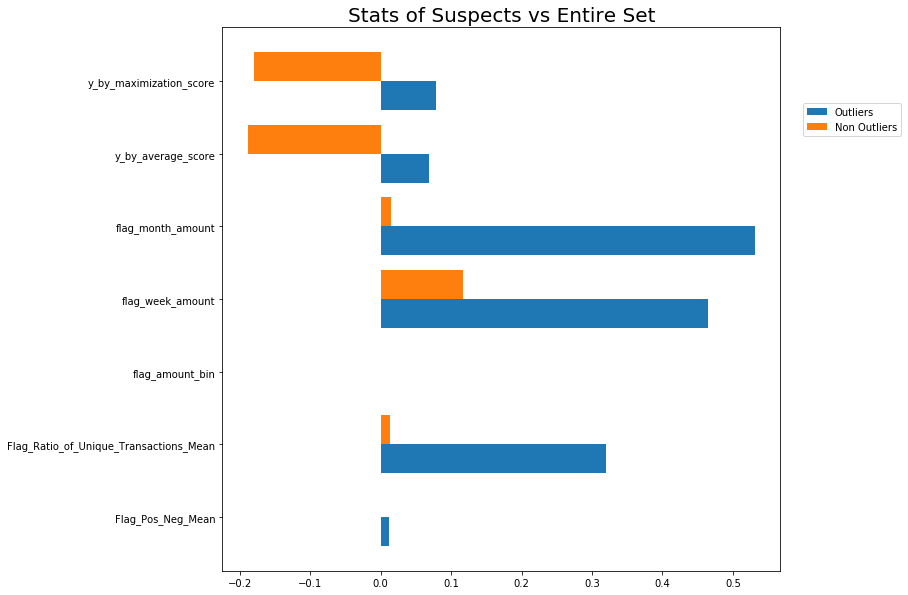

In [86]:
plt.figure(figsize=(10,10))
x = list(inspect_df.index)
_X = np.arange(len(x))
leg = ['Outliers','Non Outliers']

plt.barh(_X - 0.2, inspect_df.loc[:,'mean_outliers'], 0.4)
plt.barh(_X + 0.2, inspect_df.loc[:,'mean_non_outliers'], 0.4)
plt.yticks(_X, x) # set labels manually
plt.title('Stats of Suspects vs Entire Set',fontsize=20)
plt.legend(leg,loc=(1.04,0.8))
plt.show()


## Conclusion

The enormous gap between outliers and non-outliers show then that the algorithm was able to do its work properly and that these observations are the most likely to contain anomalies. As with any real-world data, this is an unlabeled and unsupervised technique that needs more in-depth investigation and understanding to provide a definite conclusion. However, if the goal is to create a barrier to stop unusual behavior using an isolation forest algorithm is a very useful and efficient way of doing, proven by the results produced in this exercise.